In [1]:
from IPython.display import HTML

def new_section(title):
    style = "text-align:center;background:#8BBB82;padding:25px;color:#ffffff;font-size:3em;"
    return HTML('<div style="{}">{}</div>'.format(style, title))
def new_title(title):
    style = "text-align:center;background:#8BBB82;padding:25px;color:#ffffff;font-size:4em;"
    return HTML('<div style="{}">{}</div>'.format(style, title))

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
new_title("Forest Cover Type")

<img src="./images/banner_forest.jpg",width=1920,height=540>

We are asked to predict the forest cover type (the predominant kind of tree cover) from cartographic variables. The actual forest cover type for a given 30 x 30 meter cell was determined from US Forest Service (USFS) Region 2 Resource Information System data. Independent variables were then derived from data obtained from the US Geological Survey and USFS. The data is in raw form and contains binary columns of data for qualitative independent variables such as wilderness areas and soil type.

This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

In [3]:
new_section("Table of Content")

**1. Introduction**
    1. Import libraries and modules
    2. Load data
    3. Explore data  
**2. Data Preparation**
    1. Outliers
    2. Missing values

In [4]:
new_section("1. Introduction")

In [5]:
# import libraries
import pandas as pd
import numpy as np
np.set_printoptions(threshold=np.nan)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
mycols = ["#66c2ff", "#5cd6d6", "#00cc99", "#85e085", "#ffd966", "#ffb366", "#ffb3b3", "#dab3ff", "#c2c2d6"]
sns.set_palette(palette = mycols, n_colors = 4)

from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats.stats import pearsonr

from sklearn.model_selection import GridSearchCV, ShuffleSplit

import xgboost as xgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

decimals = 2
%matplotlib inline

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


The study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. Each observation is a 30m x 30m patch. Our are asked to predict an integer classification for the forest cover type. The seven types are:

1. Spruce/Fir
2. Lodgepole Pine
3. Ponderosa Pine
4. Cottonwood/Willow
5. Aspen
6. Douglas-fir
7. Krummholz

The training set (15120 observations) contains both features and the Cover_Type. The test set contains only the features. You must predict the Cover_Type for every row in the test set (565892 observations).

Data Fields
- Elevation - Elevation in meters
- Aspect - Aspect in degrees azimuth
- Slope - Slope in degrees
- Horizontal_Distance_To_Hydrology - Horz Dist to nearest surface water features
- Vertical_Distance_To_Hydrology - Vert Dist to nearest surface water features
- Horizontal_Distance_To_Roadways - Horz Dist to nearest roadway
- Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice
- Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice
- Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice
- Horizontal_Distance_To_Fire_Points - Horz Dist to nearest wildfire ignition points
- Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
- Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation
- Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation

The wilderness areas are:

1. Rawah Wilderness Area
2. Neota Wilderness Area
3. Comanche Peak Wilderness Area
4. Cache la Poudre Wilderness Area

The soil types are:

1. Cathedral family - Rock outcrop complex, extremely stony.
2. Vanet - Ratake families complex, very stony.
3. Haploborolis - Rock outcrop complex, rubbly.
4. Ratake family - Rock outcrop complex, rubbly.
5. Vanet family - Rock outcrop complex complex, rubbly.
6. Vanet - Wetmore families - Rock outcrop complex, stony.
7. Gothic family.
8. Supervisor - Limber families complex.
9. Troutville family, very stony.
10. Bullwark - Catamount families - Rock outcrop complex, rubbly.
11. Bullwark - Catamount families - Rock land complex, rubbly.
12. Legault family - Rock land complex, stony.
13. Catamount family - Rock land - Bullwark family complex, rubbly.
14. Pachic Argiborolis - Aquolis complex.
15. unspecified in the USFS Soil and ELU Survey.
16. Cryaquolis - Cryoborolis complex.
17. Gateview family - Cryaquolis complex.
18. Rogert family, very stony.
19. Typic Cryaquolis - Borohemists complex.
20. Typic Cryaquepts - Typic Cryaquolls complex.
21. Typic Cryaquolls - Leighcan family, till substratum complex.
22. Leighcan family, till substratum, extremely bouldery.
23. Leighcan family, till substratum - Typic Cryaquolls complex.
24. Leighcan family, extremely stony.
25. Leighcan family, warm, extremely stony.
26. Granile - Catamount families complex, very stony.
27. Leighcan family, warm - Rock outcrop complex, extremely stony.
28. Leighcan family - Rock outcrop complex, extremely stony.
29. Como - Legault families complex, extremely stony.
30. Como family - Rock land - Legault family complex, extremely stony.
31. Leighcan - Catamount families complex, extremely stony.
32. Catamount family - Rock outcrop - Leighcan family complex, extremely stony.
33. Leighcan - Catamount families - Rock outcrop complex, extremely stony.
34. Cryorthents - Rock land complex, extremely stony.
35. Cryumbrepts - Rock outcrop - Cryaquepts complex.
36. Bross family - Rock land - Cryumbrepts complex, extremely stony.
37. Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.
38. Leighcan - Moran families - Cryaquolls complex, extremely stony.
39. Moran family - Cryorthents - Leighcan family complex, extremely stony.
40. Moran family - Cryorthents - Rock land complex, extremely stony.

In [6]:
# load data
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# save Cover_Type
train_ID = train['Id']
test_ID = test['Id']

# drop iD
del train['Id']
del test['Id']

# investigate shapes
print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: (15120, 55)
Test shape: (565892, 54)


In [7]:
# Display data
train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [8]:
# list features
print('List of features:')
print(train.columns)

List of features:
Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Typ

In [9]:
# explore data
print("Here are a few observations: ")
train.head()

Here are a few observations: 


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [10]:
# explore data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 55 columns):
Elevation                             15120 non-null int64
Aspect                                15120 non-null int64
Slope                                 15120 non-null int64
Horizontal_Distance_To_Hydrology      15120 non-null int64
Vertical_Distance_To_Hydrology        15120 non-null int64
Horizontal_Distance_To_Roadways       15120 non-null int64
Hillshade_9am                         15120 non-null int64
Hillshade_Noon                        15120 non-null int64
Hillshade_3pm                         15120 non-null int64
Horizontal_Distance_To_Fire_Points    15120 non-null int64
Wilderness_Area1                      15120 non-null int64
Wilderness_Area2                      15120 non-null int64
Wilderness_Area3                      15120 non-null int64
Wilderness_Area4                      15120 non-null int64
Soil_Type1                            15120 non-null int64
Soil_T

In [11]:
# explore data
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565892 entries, 0 to 565891
Data columns (total 54 columns):
Elevation                             565892 non-null int64
Aspect                                565892 non-null int64
Slope                                 565892 non-null int64
Horizontal_Distance_To_Hydrology      565892 non-null int64
Vertical_Distance_To_Hydrology        565892 non-null int64
Horizontal_Distance_To_Roadways       565892 non-null int64
Hillshade_9am                         565892 non-null int64
Hillshade_Noon                        565892 non-null int64
Hillshade_3pm                         565892 non-null int64
Horizontal_Distance_To_Fire_Points    565892 non-null int64
Wilderness_Area1                      565892 non-null int64
Wilderness_Area2                      565892 non-null int64
Wilderness_Area3                      565892 non-null int64
Wilderness_Area4                      565892 non-null int64
Soil_Type1                            565892 non-

In [12]:
# explore data
train.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,...,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,...,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493,...,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,3104.000000,261.000000,22.000000,330.000000,79.000000,2270.000000,235.000000,235.000000,167.000000,1988.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
max,3849.000000,360.000000,52.000000,1343.000000,554.000000,6890.000000,254.000000,254.000000,248.000000,6993.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


The datasets appear to be complete. There is no need to fill missing value or to drop records.

In [13]:
new_section("2. Data Exploration")

1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
Name: Cover_Type, dtype: int64


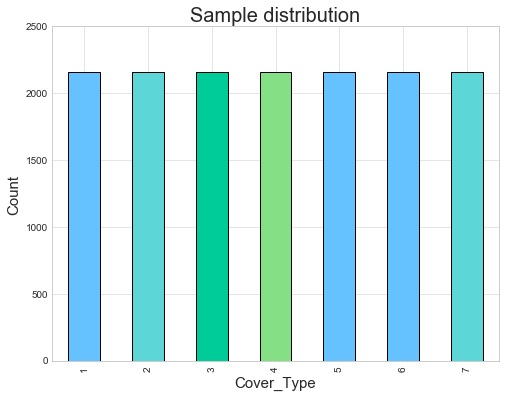

In [14]:
# Plot sample distribution
fig = plt.figure(figsize=(8, 6))
train['Cover_Type'].value_counts().sort_index().plot(kind='bar')
plt.title('Sample distribution',fontsize=20)
plt.xlabel('Cover_Type',fontsize=15)
plt.ylabel('Count',fontsize=15);
print(train['Cover_Type'].value_counts().sort_index());

The target feature is homogeneouslybetween all 7 output classes.

In [15]:
for col in train.columns:
    print(col)

Elevation
Aspect
Slope
Horizontal_Distance_To_Hydrology
Vertical_Distance_To_Hydrology
Horizontal_Distance_To_Roadways
Hillshade_9am
Hillshade_Noon
Hillshade_3pm
Horizontal_Distance_To_Fire_Points
Wilderness_Area1
Wilderness_Area2
Wilderness_Area3
Wilderness_Area4
Soil_Type1
Soil_Type2
Soil_Type3
Soil_Type4
Soil_Type5
Soil_Type6
Soil_Type7
Soil_Type8
Soil_Type9
Soil_Type10
Soil_Type11
Soil_Type12
Soil_Type13
Soil_Type14
Soil_Type15
Soil_Type16
Soil_Type17
Soil_Type18
Soil_Type19
Soil_Type20
Soil_Type21
Soil_Type22
Soil_Type23
Soil_Type24
Soil_Type25
Soil_Type26
Soil_Type27
Soil_Type28
Soil_Type29
Soil_Type30
Soil_Type31
Soil_Type32
Soil_Type33
Soil_Type34
Soil_Type35
Soil_Type36
Soil_Type37
Soil_Type38
Soil_Type39
Soil_Type40
Cover_Type


**Elevation**

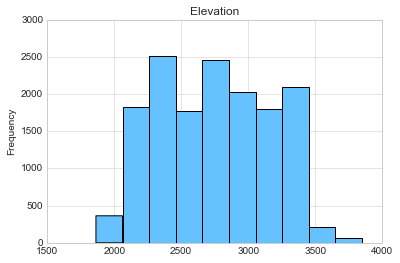

In [16]:
feature = 'Elevation'
# plot histogram
train['Elevation'].plot(kind='hist')
plt.title('Elevation');

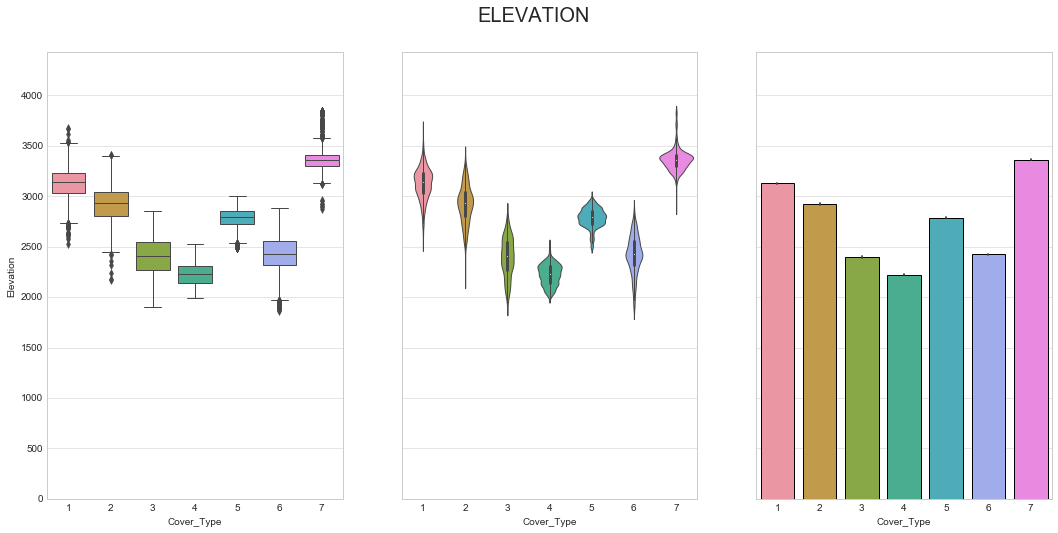

In [17]:
def Plot_3_plots(feature):
    fig, axarr = plt.subplots(1,3,figsize =(18, 8),sharey=True)
    fig.suptitle(feature.upper(),fontsize=20)
    
    # plot
    sns.boxplot(x='Cover_Type', y=feature,data=train,
                ax=axarr[0])
    
    # plot
    plot = sns.violinplot(x='Cover_Type', y=feature,data=train, showmeans=False,
                   showmedians=False,showextrema=False,ax=axarr[1])
    axarr[1].set_ylabel("")
    
    # purpose
    sns.barplot(x='Cover_Type', y=feature,data=train,
                ax=axarr[2])
    axarr[2].set_ylabel("")
    axarr[0].set_ylim(0,train[feature].max()*1.15)
    return;
Plot_3_plots('Elevation')

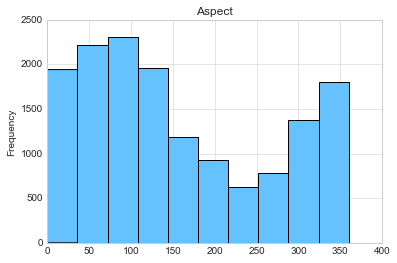

In [18]:
feature = 'Aspect'
# plot histogram
train['Aspect'].plot(kind='hist')
plt.title('Aspect');

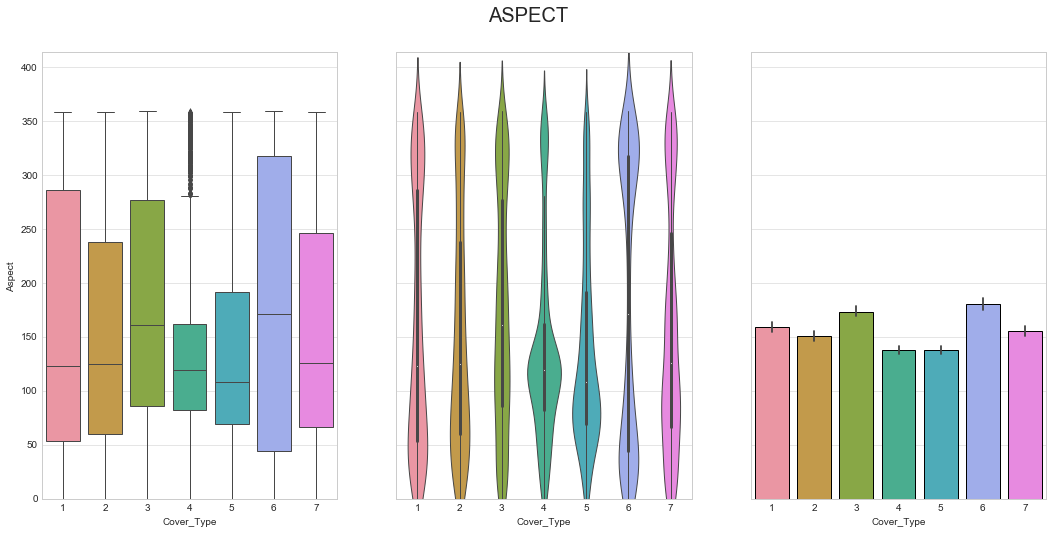

In [19]:
Plot_3_plots('Aspect')

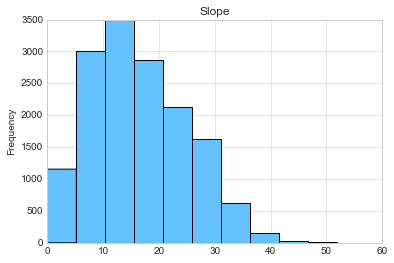

In [20]:
feature = 'Slope'
# plot histogram
train['Slope'].plot(kind='hist')
plt.title('Slope');

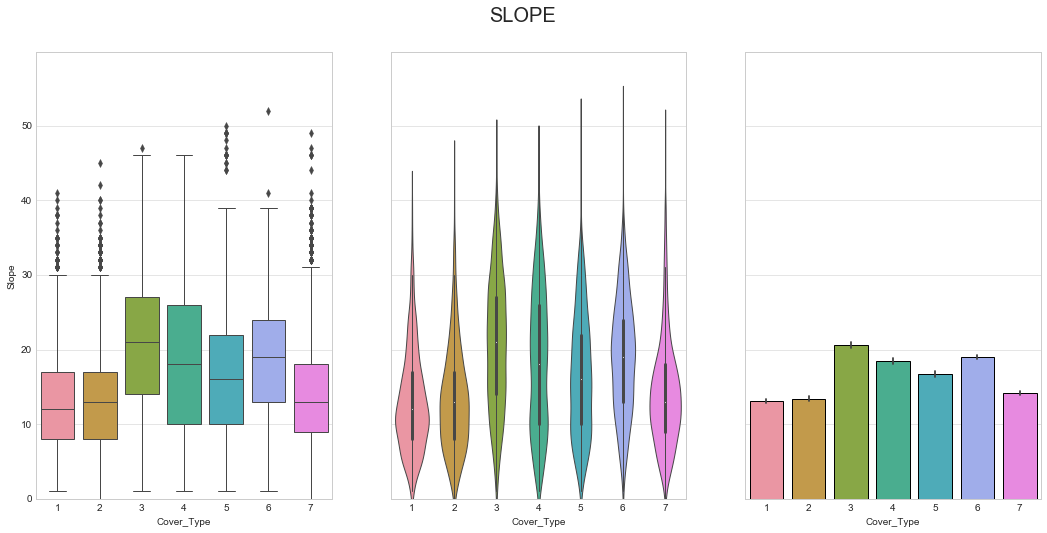

In [21]:
Plot_3_plots('Slope')

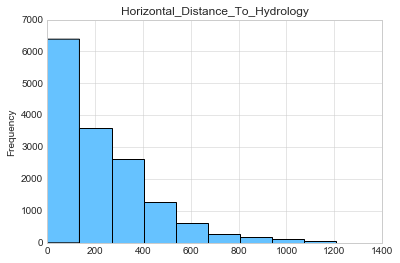

In [22]:
feature = 'Horizontal_Distance_To_Hydrology'
# plot histogram
train['Horizontal_Distance_To_Hydrology'].plot(kind='hist')
plt.title('Horizontal_Distance_To_Hydrology');

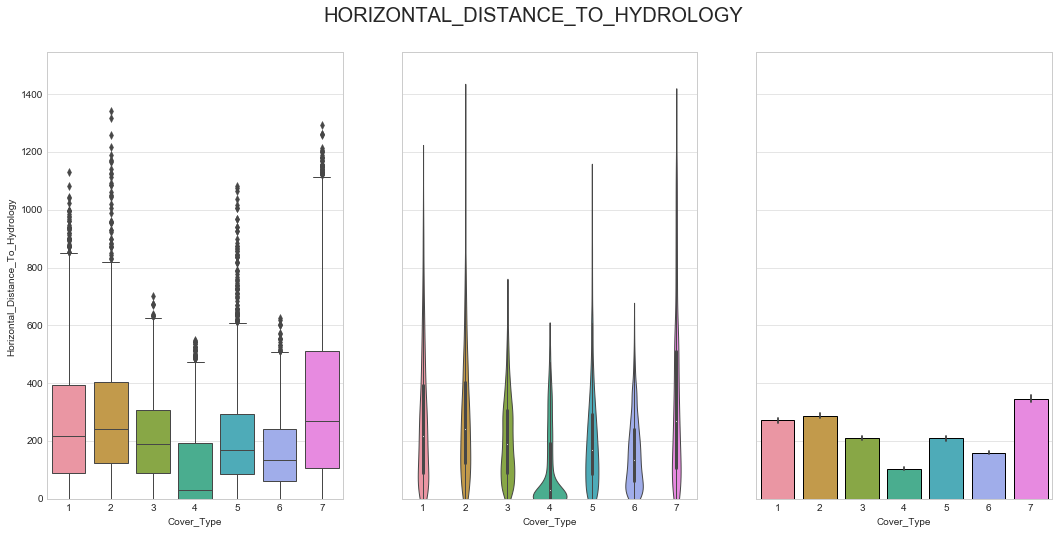

In [23]:
Plot_3_plots('Horizontal_Distance_To_Hydrology')

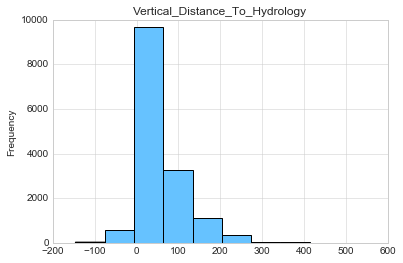

In [24]:
feature = 'Vertical_Distance_To_Hydrology'
# plot histogram
train['Vertical_Distance_To_Hydrology'].plot(kind='hist')
plt.title('Vertical_Distance_To_Hydrology');

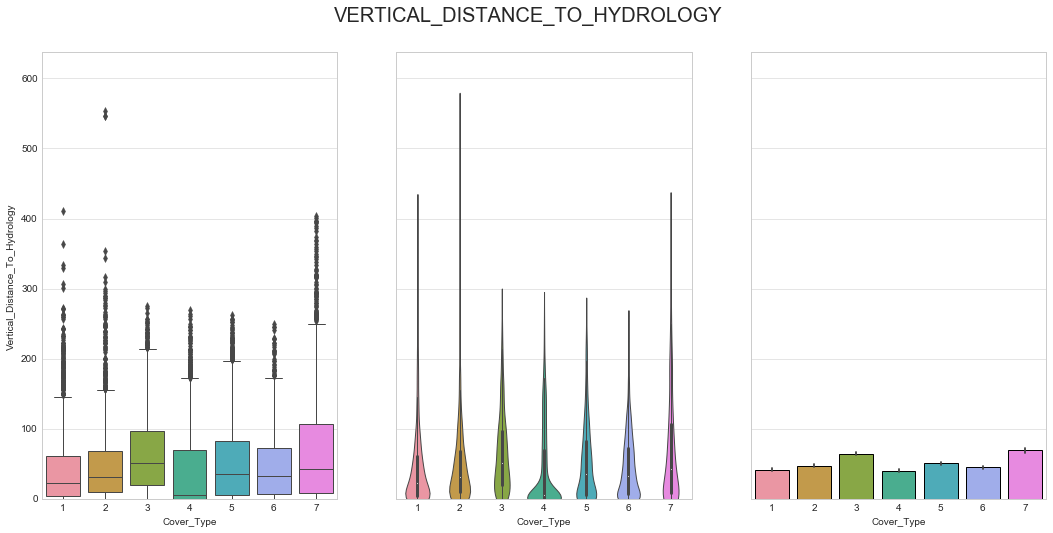

In [25]:
Plot_3_plots('Vertical_Distance_To_Hydrology')

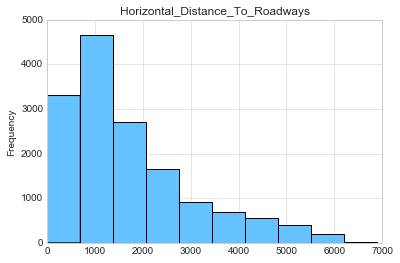

In [26]:
feature = 'Horizontal_Distance_To_Roadways'
# plot histogram
train['Horizontal_Distance_To_Roadways'].plot(kind='hist')
plt.title('Horizontal_Distance_To_Roadways');

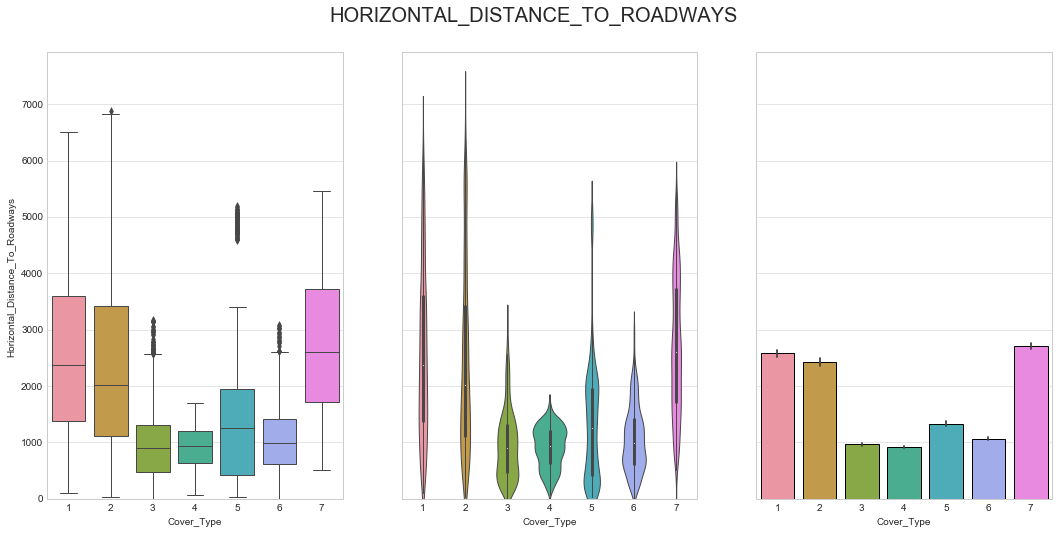

In [27]:
Plot_3_plots('Horizontal_Distance_To_Roadways')

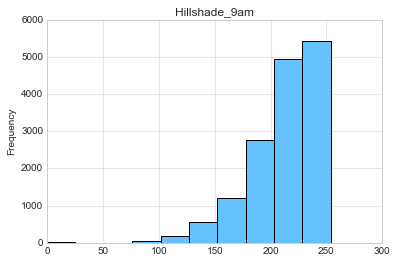

In [28]:
feature = 'Hillshade_9am'
# plot histogram
train['Hillshade_9am'].plot(kind='hist')
plt.title('Hillshade_9am');

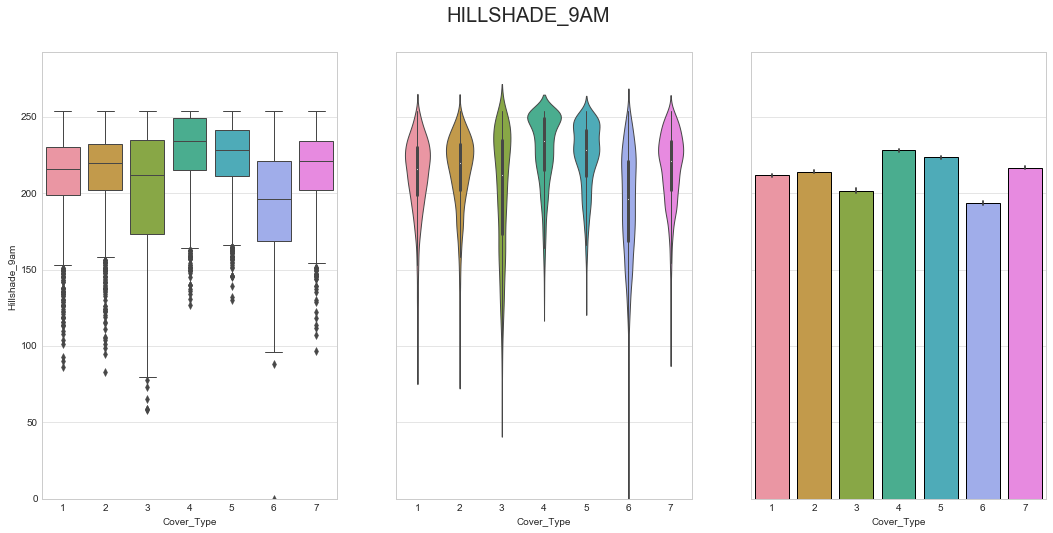

In [29]:
Plot_3_plots('Hillshade_9am')

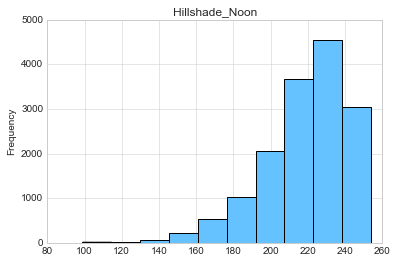

In [30]:
feature = 'Hillshade_Noon'
# plot histogram
train['Hillshade_Noon'].plot(kind='hist')
plt.title('Hillshade_Noon');

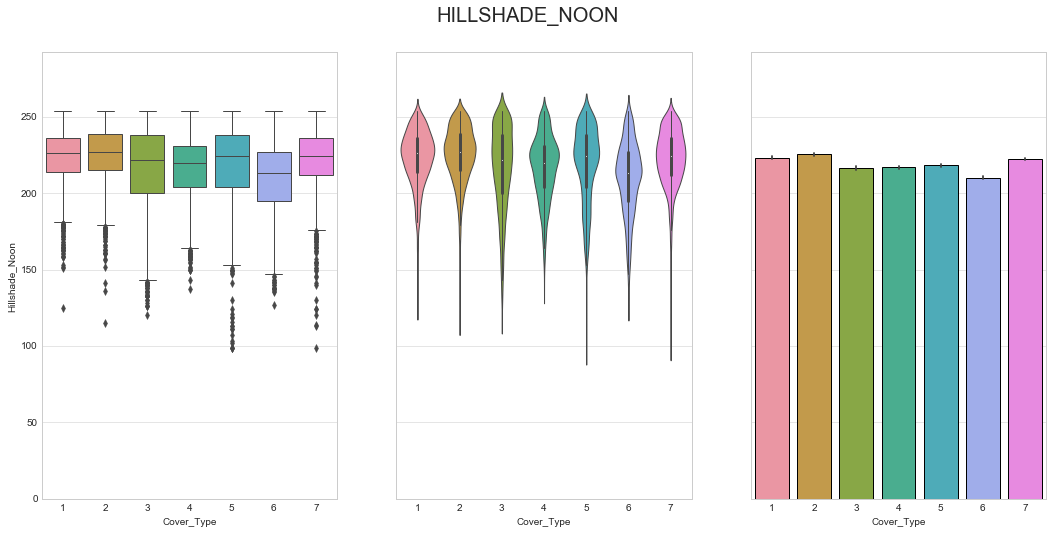

In [31]:
Plot_3_plots('Hillshade_Noon')

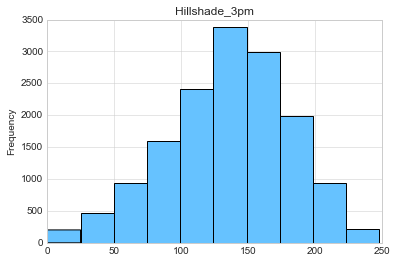

In [32]:
feature = 'Hillshade_3pm'
# plot histogram
train['Hillshade_3pm'].plot(kind='hist')
plt.title('Hillshade_3pm');

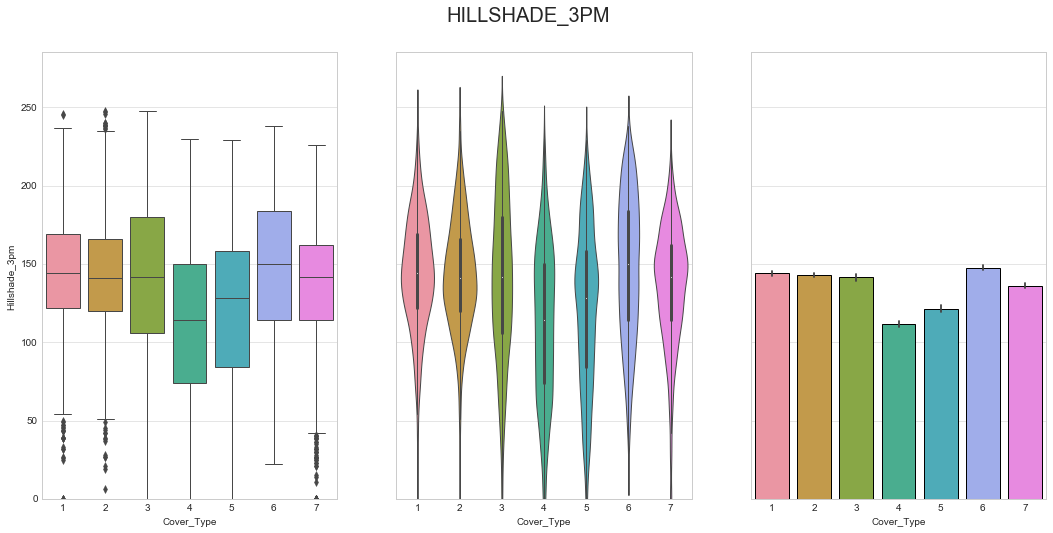

In [33]:
Plot_3_plots('Hillshade_3pm')

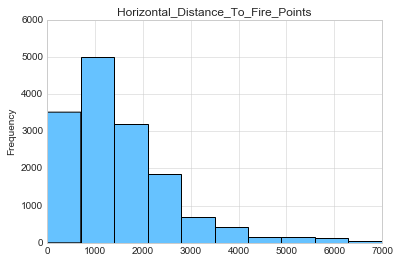

In [34]:
feature = 'Horizontal_Distance_To_Fire_Points'
# plot histogram
train['Horizontal_Distance_To_Fire_Points'].plot(kind='hist')
plt.title('Horizontal_Distance_To_Fire_Points');

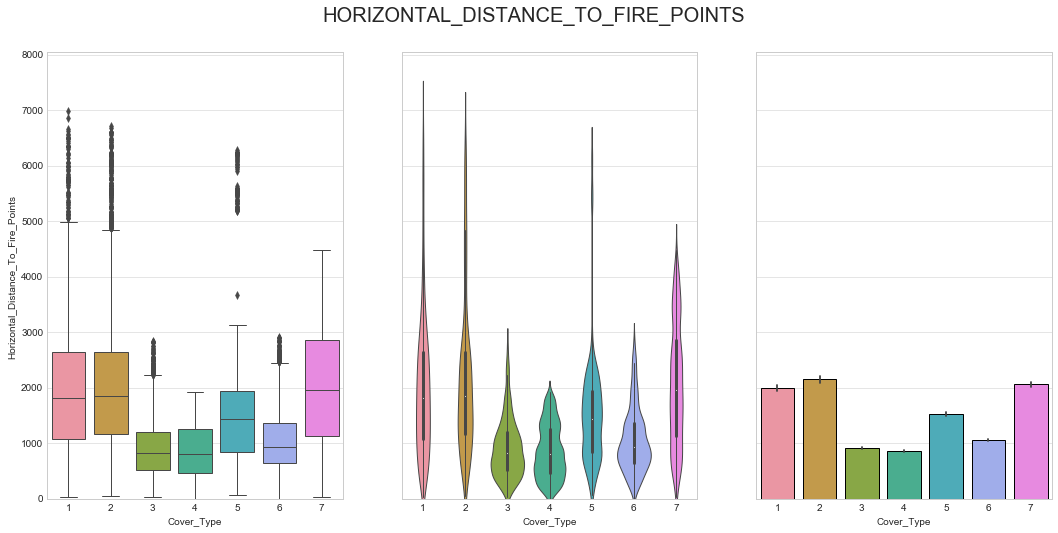

In [35]:
Plot_3_plots('Horizontal_Distance_To_Fire_Points')

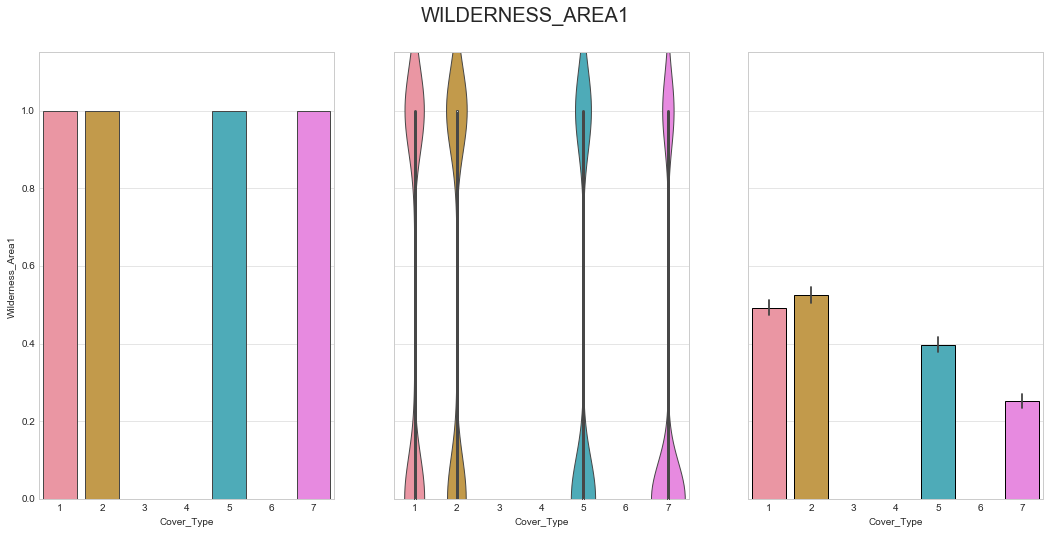

In [36]:
Plot_3_plots('Wilderness_Area1')

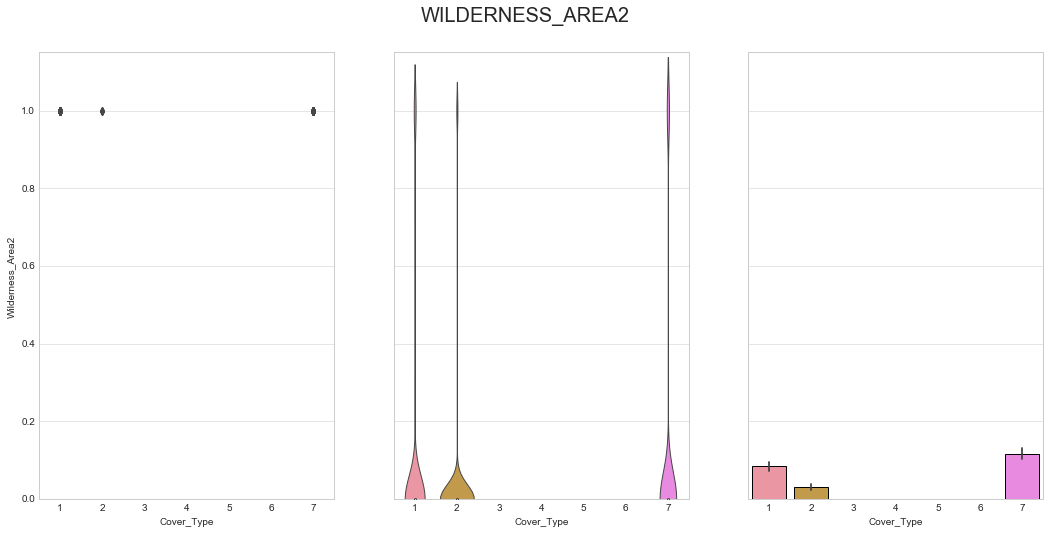

In [37]:
Plot_3_plots('Wilderness_Area2')

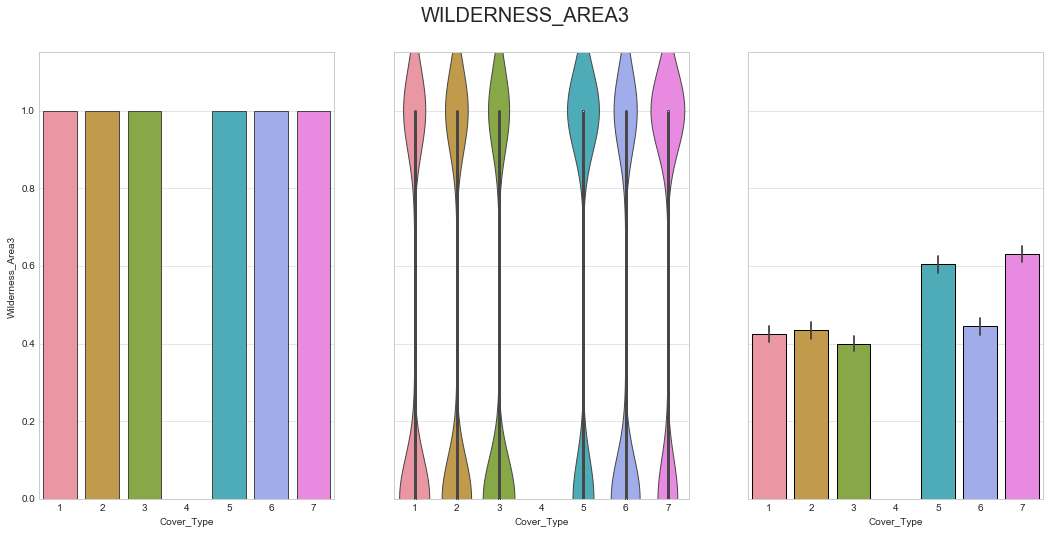

In [38]:
Plot_3_plots('Wilderness_Area3')

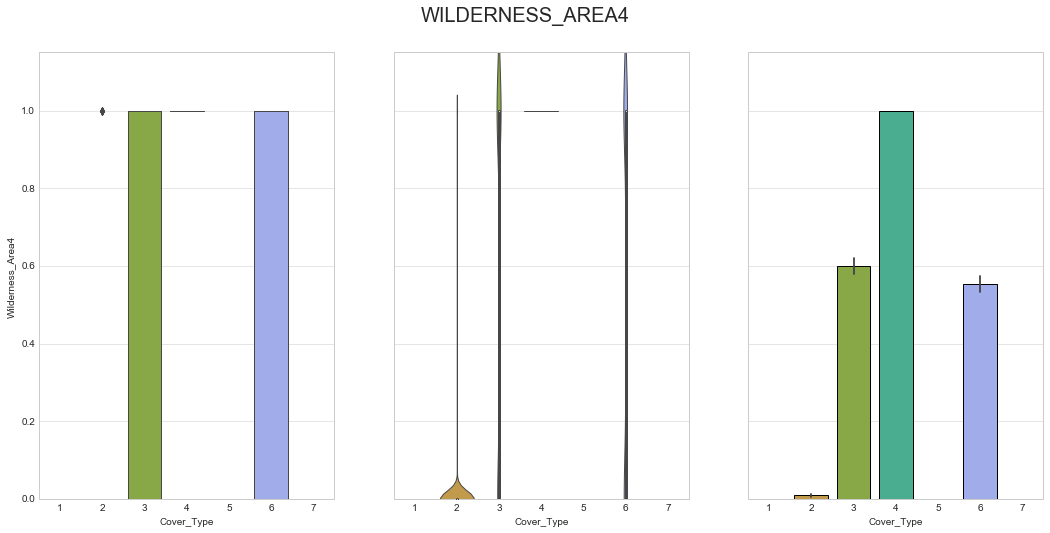

In [39]:
Plot_3_plots('Wilderness_Area4')

In [40]:
# Data distribution
train.sum(axis=0).sort_values(ascending=True)[0:10]

Soil_Type15     0
Soil_Type7      0
Soil_Type8      1
Soil_Type25     1
Soil_Type28     9
Soil_Type36    10
Soil_Type9     10
Soil_Type27    15
Soil_Type21    16
Soil_Type34    22
dtype: int64

From the above table, we observe that the features Soil_Type7 and Soil_Type15 do not have any positive observations. For this reason, we drop the two features.

In [41]:
# Data distribution Soil_Type
soil_types = ["Soil_Type" + str(i) for i in range(1,41)][0:5]
train[soil_types].sum(axis=0).sort_values(ascending=False)

Soil_Type3    962
Soil_Type4    843
Soil_Type2    623
Soil_Type1    355
Soil_Type5    165
dtype: int64

None of the soil type has a positive observation for all the records.

In [42]:
# drop iD
del train['Soil_Type7']
del test['Soil_Type7']
del train['Soil_Type15']
del test['Soil_Type15']

In [43]:
new_section("3. Feature Correlation")

We produce a pair plot to evaluate the correlation between the target and the predictors.

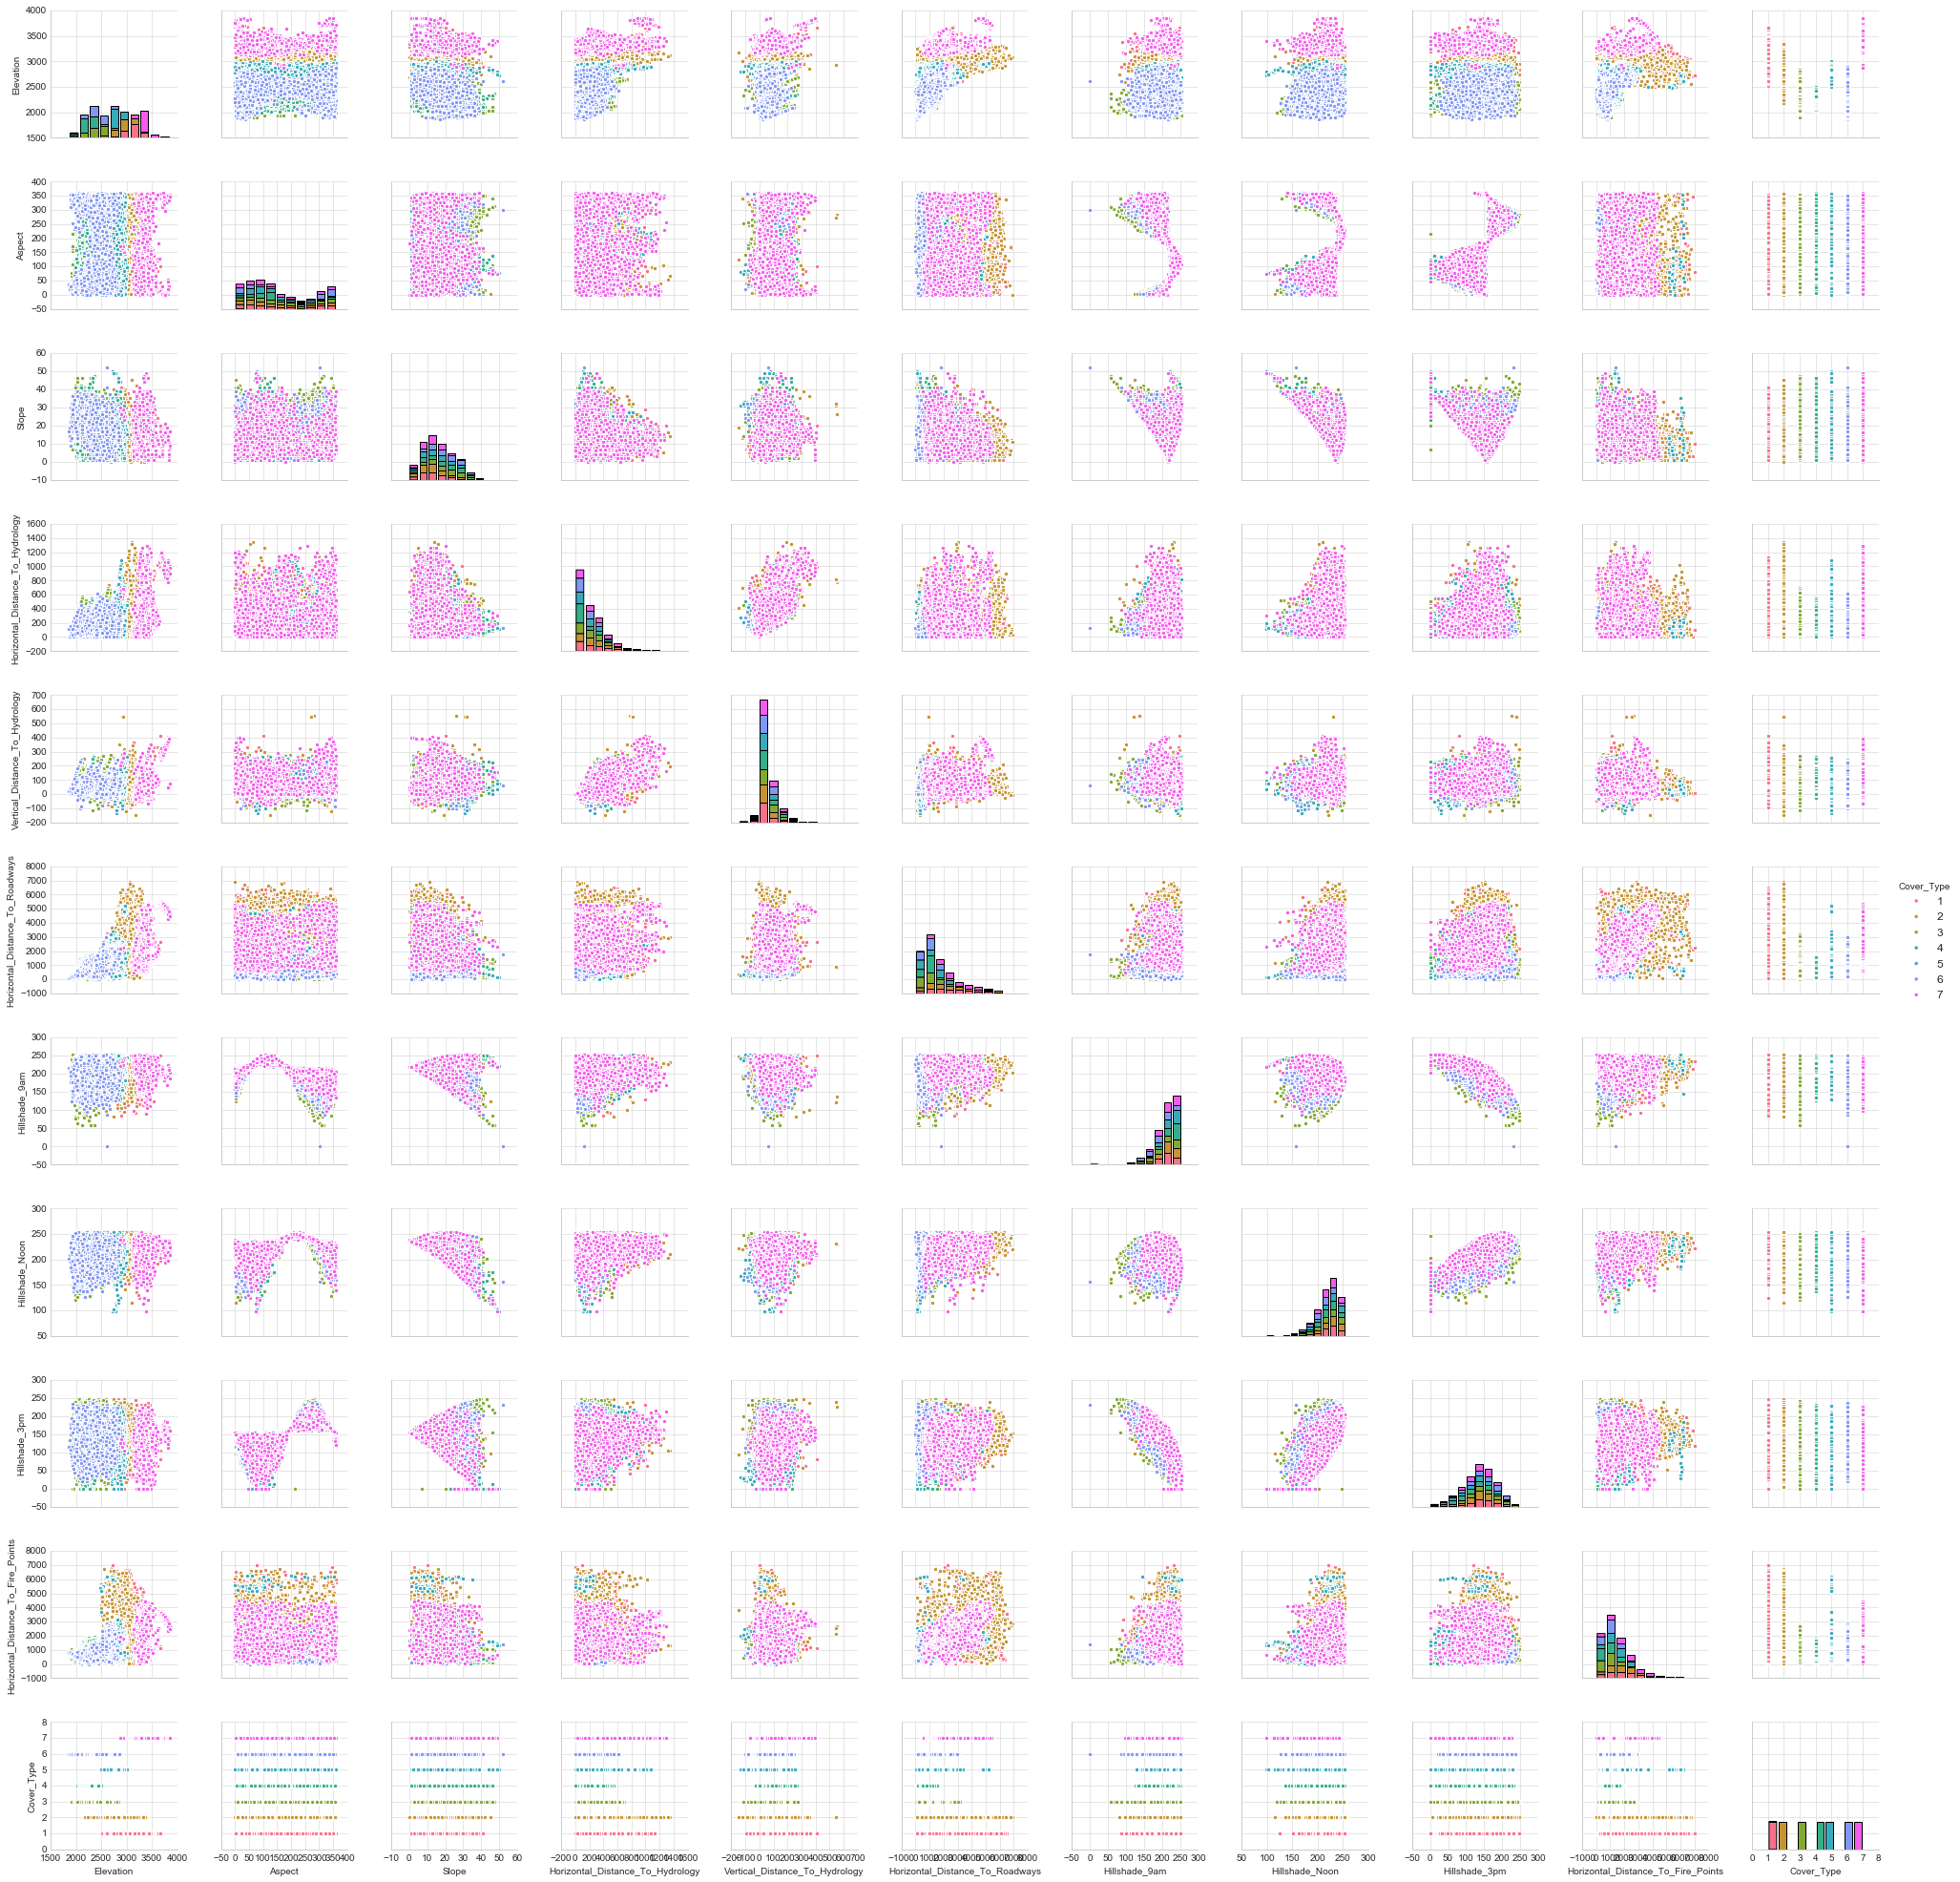

In [44]:
sns.pairplot(train[['Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
        'Cover_Type']], hue='Cover_Type')

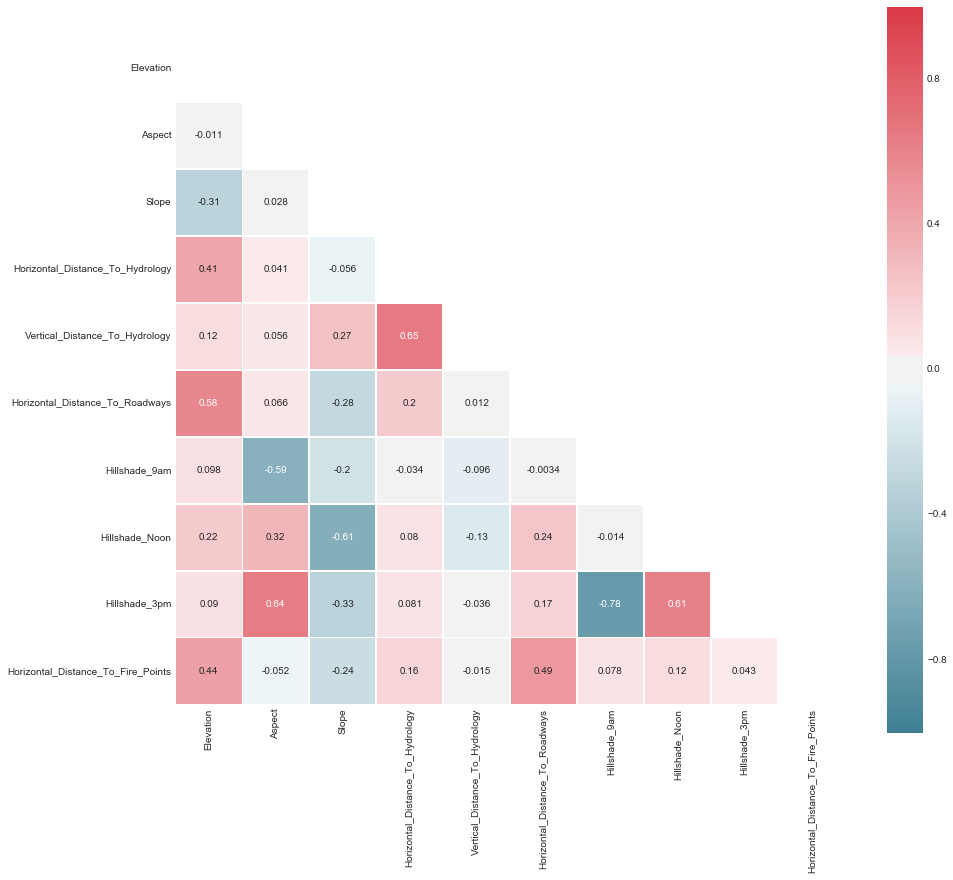

In [45]:
# Compute the correlation matrix
corr = train[['Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 13))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0,vmin=-1.0, center=0,annot=True,
            square=True, linewidths=.5);

**COMMENT**:
From the table above, we can notice the following large **positive** correlations:
1. 0.65 between **Vertical_Distance_To_Hydrology** and **Horizontal_Distance_To_Hydrology**
2. 0.64 between **Hillshade_3pm** and **Aspect**
3. 0.61 between **Hillshade_3pm** and **Hillshade_Noon**
4. 0.58 between **Horizontal_Distance_To_Roadways** and **Elevation**
  
From the table above, we can notice the following large **negative** correlations:
1. -0.78 between **Hillshade_3pm** and **Hillshade_9am**
2. -0.61 between **Slope** and **Hillshade_Noon**
3. -0.59 between **Hillshade_9am** and **Aspect**

In [46]:
new_section("4. Feature Engineering")

**Soil Types**

In [47]:
print("Maximum number of soil type per record:",train[soil_types].sum(axis=1).max())
print("Minimum number of soil type per record:",train[soil_types].sum(axis=1).min())

Maximum number of soil type per record: 1
Minimum number of soil type per record: 0


We create a new binary feature: *has_soil_type*.

In [48]:
train['has_soil_type'] = train[soil_types].sum(axis=1)
test['has_soil_type'] = test[soil_types].sum(axis=1)
train['has_soil_type'].value_counts()

0    12172
1     2948
Name: has_soil_type, dtype: int64

**COMMENT**
Most of the records do not contain any soil type data.

**********
**Wilderness Area**

In [49]:
wild_area = ['Wilderness_Area1','Wilderness_Area2','Wilderness_Area3','Wilderness_Area4']

In [50]:
print("Maximum number of wilderness area per record:",train[wild_area].sum(axis=1).max())
print("Minimum number of wilderness area per record:",train[wild_area].sum(axis=1).min())

Maximum number of wilderness area per record: 1
Minimum number of wilderness area per record: 1


Only a single wilderness area feature is provided for each record. Therefore, there is not need to adjust the current data structure.

**********
**Polynomial features**

Because of the nature of the distance features, a few polynomial features are created and various distance combinations between the hydrology, fire point, and roadway are created.

In [51]:
# train data
train['Elevation_2'] = train['Elevation'] ** 2
train['Aspect_2'] = train['Aspect'] ** 2
train['Slope_2'] = train['Slope'] ** 2
train['Horizontal_Distance_To_Hydrology_2'] = train['Horizontal_Distance_To_Hydrology'] ** 2
train['Vertical_Distance_To_Hydrology_2'] = train['Vertical_Distance_To_Hydrology'] ** 2
train['Horizontal_Distance_To_Roadways_2'] = train['Horizontal_Distance_To_Roadways'] ** 2
train['Horizontal_Distance_To_Fire_Points_2'] = train['Horizontal_Distance_To_Fire_Points'] ** 2

# test data
test['Elevation_2'] = test['Elevation'] ** 2
test['Aspect_2'] = test['Aspect'] ** 2
test['Slope_2'] = test['Slope'] ** 2
test['Horizontal_Distance_To_Hydrology_2'] = test['Horizontal_Distance_To_Hydrology'] ** 2
test['Vertical_Distance_To_Hydrology_2'] = test['Vertical_Distance_To_Hydrology'] ** 2
test['Horizontal_Distance_To_Roadways_2'] = test['Horizontal_Distance_To_Roadways'] ** 2
test['Horizontal_Distance_To_Fire_Points_2'] = test['Horizontal_Distance_To_Fire_Points'] ** 2

**********
**Distance combinations**

In [52]:
# Hydro (V+H), Fire(), Roadways(H)
train['Distance_To_Hydrology'] = np.sqrt(train['Horizontal_Distance_To_Hydrology_2']+train['Vertical_Distance_To_Hydrology_2'])
test['Distance_To_Hydrology'] = np.sqrt(test['Horizontal_Distance_To_Hydrology_2']+test['Vertical_Distance_To_Hydrology_2'])

# H to F 
train['H_to_F_sum'] = np.abs(train['Horizontal_Distance_To_Hydrology'] + train['Horizontal_Distance_To_Fire_Points'])
train['H_to_F_sum'] = np.abs(train['Horizontal_Distance_To_Hydrology'] - train['Horizontal_Distance_To_Fire_Points'])

test['H_to_F_sum'] = np.abs(test['Horizontal_Distance_To_Hydrology'] + test['Horizontal_Distance_To_Fire_Points'])
test['H_to_F_sum'] = np.abs(test['Horizontal_Distance_To_Hydrology'] - test['Horizontal_Distance_To_Fire_Points'])

# H to R
train['H_to_R_sum'] = np.abs(train['Horizontal_Distance_To_Hydrology'] + train['Horizontal_Distance_To_Roadways'])
train['H_to_R_sum'] = np.abs(train['Horizontal_Distance_To_Hydrology'] - train['Horizontal_Distance_To_Roadways'])

test['H_to_R_sum'] = np.abs(test['Horizontal_Distance_To_Hydrology'] + test['Horizontal_Distance_To_Roadways'])
test['H_to_R_sum'] = np.abs(test['Horizontal_Distance_To_Hydrology'] - test['Horizontal_Distance_To_Roadways'])

# R to F
train['R_to_F_sum'] = np.abs(train['Horizontal_Distance_To_Roadways'] + train['Horizontal_Distance_To_Fire_Points'])
train['R_to_F_sum'] = np.abs(train['Horizontal_Distance_To_Roadways'] - train['Horizontal_Distance_To_Fire_Points'])

test['R_to_F_sum'] = np.abs(test['Horizontal_Distance_To_Roadways'] + test['Horizontal_Distance_To_Fire_Points'])
test['R_to_F_sum'] = np.abs(test['Horizontal_Distance_To_Roadways'] - test['Horizontal_Distance_To_Fire_Points'])

# mean distances
train['mean_dist'] = (train['Horizontal_Distance_To_Hydrology'] + train['Horizontal_Distance_To_Fire_Points'] + train['Horizontal_Distance_To_Roadways'])/3
test['mean_dist'] = (test['Horizontal_Distance_To_Hydrology'] + test['Horizontal_Distance_To_Fire_Points'] + test['Horizontal_Distance_To_Roadways'])/3

# slope Hydrology
train['slope_H'] = train['Vertical_Distance_To_Hydrology'] / train['Horizontal_Distance_To_Hydrology']
test['slope_H'] = test['Vertical_Distance_To_Hydrology'] / test['Horizontal_Distance_To_Hydrology']

train['slope_H'] = train['slope_H'].map(lambda x: 0 if np.isnan(x) else x)
test['slope_H'] = test['slope_H'].map(lambda x: 0 if np.isnan(x) else x)

In [53]:
new_section("5. Build Models")

The following classifiers are used to predict the forest types:
1. Logistic Regression
2. Random Forest Classifier
3. Adaboost
4. Support Vector Classifier (SVC)
5. XGB Classifier

In [54]:
# import modules
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# cross validation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

In [55]:
# format the data
X_train = train[train.columns.difference(['Cover_Type'])]
X_test = test[train.columns.difference(['Cover_Type'])]
y_train = train['Cover_Type']

In [56]:
# train and test sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=1)

In [57]:
# considered models
models = [LogisticRegression(),RandomForestClassifier(), SVC(),
          XGBClassifier()]

shuff = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# results summary
summary_cols = ['Model', 'Parameters (Pre)', 'Training accuracy (Pre)', 'Validation accuracy (Pre)', 'Parameters (Post)', 'Training accuracy (Post)', 'Validation accuracy (Post)']
summary_df = pd.DataFrame(columns=summary_cols)

for idx, algo in enumerate(models):
    
    # identify the model
    name = algo.__class__.__name__
    summary_df.loc[idx,'Model'] = name
    summary_df.loc[idx,'Parameters (Pre)'] = str(algo.get_params())
    
    # fit model
    algo.fit(X_train, y_train)
    
    # compute metrics
    training_results = (cross_val_score(algo, X_train, y_train, cv = shuff, scoring= 'accuracy').mean())
    val_results = accuracy_score(y_val, algo.predict(X_val))
    
    summary_df.loc[idx,'Training accuracy (Pre)'] = training_results * 100
    summary_df.loc[idx,'Validation accuracy (Pre)'] = val_results * 100
    print(algo.__class__.__name__, 'trained...')

summary_df['Training accuracy (Pre)'] = summary_df['Training accuracy (Pre)'].apply(lambda x: round(x, decimals))
summary_df['Validation accuracy (Pre)'] = summary_df['Validation accuracy (Pre)'].apply(lambda x: round(x, decimals))

print("Summary without hyper-parameter tuning:")
summary_df

LogisticRegression trained...
RandomForestClassifier trained...
SVC trained...
XGBClassifier trained...
Summary without hyper-parameter tuning:


,Model,Parameters (Pre),Training accuracy (Pre),Validation accuracy (Pre),Parameters (Post),Training accuracy (Post),Validation accuracy (Post)
0,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",53.66,54.14,NaN,NaN,NaN
1,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",83.33,85.36,NaN,NaN,NaN
2,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",13.96,13.56,NaN,NaN,NaN
3,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",76.63,77.05,NaN,NaN,NaN


In [58]:
models = [LogisticRegression() ,RandomForestClassifier(), XGBClassifier()]

# LogisticRegression
LR_params = {'penalty':['l2'], 'C':10**np.linspace(1,3,30)}

# RandomForestClassifier
RF_params = {'n_estimators':[100, 200], 'max_depth':[None,10,50],'min_samples_leaf':[1,5,10],
             'max_features':['auto','sqrt','log2',None]}


# XGBClassifier
XGB_params = {'min_child_weight': [1, 5, 10], 'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]}

# parameters
params = [LR_params,RF_params,XGB_params]

for idx, algo in enumerate(models):
    # create grid
    grid_alg = GridSearchCV(estimator=algo, param_grid=params[idx],scoring='accuracy',verbose=True)
    
    #set name and parameters
    model_name = algo.__class__.__name__
    
    # fit model and retrieve the best set of hyper-parameters
    grid_alg.fit(X_train, y_train)
    gs_best = grid_alg.best_estimator_
    summary_df.loc[idx, 'Parameters (Post)'] = str(grid_alg.best_params_)
    
    # score
    after_training_results = grid_alg.best_score_
    after_val_results = accuracy_score(y_val, grid_alg.predict(X_val))
    
    summary_df.loc[idx, 'Training accuracy (Post)'] = (after_training_results)*100
    summary_df.loc[idx, 'Validation accuracy (Post)'] = (after_val_results)*100
    print(algo.__class__.__name__, 'trained...')
    
summary_df['Training accuracy (Post)'] = summary_df['Training accuracy (Post)'].apply(lambda x: round(x, decimals))
summary_df['Validation accuracy (Post)'] = summary_df['Validation accuracy (Post)'].apply(lambda x: round(x, decimals))

print("Summary:")
summary_df

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.4min finished


LogisticRegression trained...
Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed: 23.0min finished


RandomForestClassifier trained...
Fitting 3 folds for each of 405 candidates, totalling 1215 fits


[Parallel(n_jobs=1)]: Done 1215 out of 1215 | elapsed: 299.6min finished


XGBClassifier trained...
Summary:


,Model,Parameters (Pre),Training accuracy (Pre),Validation accuracy (Pre),Parameters (Post),Training accuracy (Post),Validation accuracy (Post)
0,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",53.66,54.14,"{'C': 30.39195382313198, 'penalty': 'l2'}",54.10,51.81
1,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",83.33,85.36,"{'max_depth': None, 'max_features': 'sqrt', 'm...",85.77,87.57
2,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",13.96,13.56,"{'colsample_bytree': 0.8, 'gamma': 0.5, 'max_d...",82.22,83.16
3,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",76.63,77.05,NaN,NaN,NaN


In [64]:
# update grid
summary_df.loc[2, 'Parameters (Post)'] = np.NaN
summary_df.loc[2, 'Training accuracy (Post)'] = np.NaN
summary_df.loc[2, 'Validation accuracy (Post)'] = np.NaN

summary_df.loc[3, 'Parameters (Post)'] = str(grid_alg.best_params_)
summary_df.loc[3, 'Training accuracy (Post)'] = (after_training_results)*100
summary_df.loc[3, 'Validation accuracy (Post)'] = (after_val_results)*100

summary_df

,Model,Parameters (Pre),Training accuracy (Pre),Validation accuracy (Pre),Parameters (Post),Training accuracy (Post),Validation accuracy (Post)
0,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",53.66,54.14,"{'C': 30.39195382313198, 'penalty': 'l2'}",54.100000,51.810000
1,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",83.33,85.36,"{'max_depth': None, 'max_features': 'sqrt', 'm...",85.770000,87.570000
2,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",13.96,13.56,NaN,NaN,NaN
3,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",76.63,77.05,"{'colsample_bytree': 0.8, 'gamma': 0.5, 'max_d...",82.218443,83.156966
